In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys
import os

In [22]:
# Hole das aktuelle Arbeitsverzeichnis (für Jupyter)
script_dir = os.getcwd()

# Projekt-Root: z.B. ein Verzeichnis darüber, wenn dein Notebook in einem Unterordner liegt
project_root = os.path.abspath(os.path.join(script_dir, ".."))

# Pfad zum Projekt-Root dem sys.path hinzufügen (falls noch nicht vorhanden)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Projekt-Root hinzugefügt:", project_root)

Projekt-Root hinzugefügt: c:\Users\migue\OneDrive\Dokumente\GitHub\topic01_team03


In [27]:
# ------------------- Bilder laden -------------------
from src.imread_all import load_n2dh_gowt1_images, load_n2dl_hela_images, load_nih3t3_images

imgs_N2DH_GOWT1, gts_N2DH_GOWT1, img_paths_N2DH_GOWT1, gt_paths_N2DH_GOWT1 = load_n2dh_gowt1_images()
imgs_N2DL_HeLa, gts_N2DL_HeLa, img_paths_N2DL_HeLa, gt_paths_N2DL_HeLa = load_n2dl_hela_images()
imgs_NIH3T3, gts_NIH3T3, img_paths_NIH3T3, gt_paths_NIH3T3 = load_nih3t3_images()


In [ ]:
from skimage.filters import threshold_multiotsu
from skimage import img_as_ubyte

from src.Dice_Score import dice_score

# ------------------- Multi-Otsu-basierte Maske -------------------

def apply_multiotsu_mask_class1_foreground(img):
    """
    Nutzt Multi-Otsu und weist nur Klasse 1 (zwischen den ersten beiden Schwellen)
    als Vordergrund zu. Klasse 0 (dunkel) und Klassen >=2 (heller) werden Hintergrund.
    """
    img_u8 = img_as_ubyte(img)
    thresholds = threshold_multiotsu(img_u8, classes=3)
    regions = np.digitize(img_u8, bins=thresholds)
    
    # Nur Klasse 1 wird Vordergrund
    mask = (regions == 1)
    return mask

# ------------------- Dice-Scores berechnen -------------------
def calculate_multiotsu_dice_scores(imgs, gts):
    scores = []
    for img, gt in zip(imgs, gts):
        mask = apply_multiotsu_mask_class1_foreground(img)
        gt_binary = gt > 0
        scores.append(dice_score(mask, gt_binary))
    return scores


In [28]:
# ------------------- Dice-Scores berechnen -------------------

dice_nih = calculate_multiotsu_dice_scores(imgs_NIH3T3, gts_NIH3T3)

# Als normale Floats ausgeben
dice_nih_multi   = [float(score) for score in dice_nih]

# Ergebnisse ausgeben

print("NIH3T3_Scores =", list(dice_nih_multi))

NIH3T3_Scores = []


In [29]:
from src.Dice_Score_comparison import calculate_dice_scores_global
# --------------------------------------------------------------------------
# Compute Dice scores for each dataset
dice_nih = calculate_dice_scores_global(imgs_NIH3T3, gts_NIH3T3)

# Convert numpy floats to plain Python floats for clearer output
dice_nih_OO = [float(score) for score in dice_nih]

# Print scores in a readable format
print("NIH3T3_Scores =", list(dice_nih_OO))

NIH3T3_Scores = []


Dice scores identical to reference: False


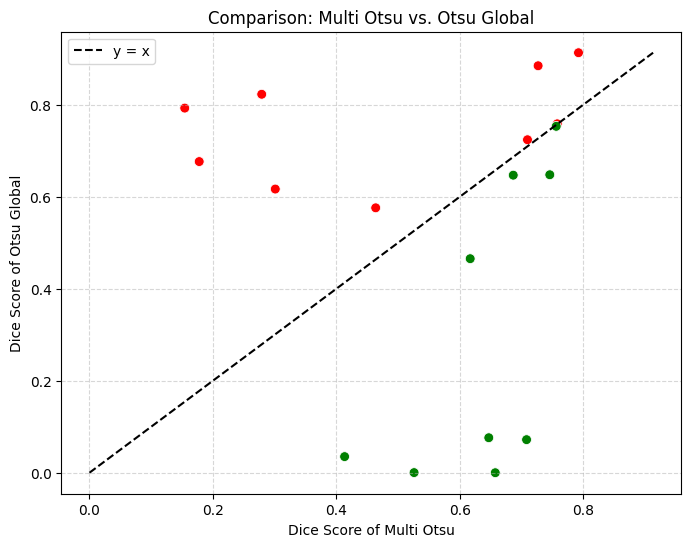

In [28]:
# Define Dice scores obtained from both methods for comparison.
# package_dice_scores: Dice scores from the reference implementation.
# our_dice_scores: Dice scores from our custom implementation.
dice_scores_multi_OO = dice_nih_OO

dice_scores_multi = dice_nih_multi
# Verify whether both lists are identical element-wise.
are_identical_multi = dice_scores_multi_OO == dice_scores_multi
print("Dice scores identical to reference:", are_identical_multi)

# Compute linear regression between our Dice scores (x) and package Dice scores (y).
slope, intercept = np.polyfit(dice_scores_multi, dice_scores_multi_OO, 1)

# Determine point colors for scatter plot based on relative performance.
colors = []
for x, y in zip(dice_scores_multi, dice_scores_multi_OO):
    if np.isclose(y, x):
        colors.append("blue")   # scores are essentially identical
    elif y > x:
        colors.append("red")    # package score higher → our method worse
    else:
        colors.append("green")  # our score higher → our method better

# Prepare DataFrame for seaborn plotting.
df = pd.DataFrame({
    "Multi": dice_scores_multi,
    "Otsu Global": dice_scores_multi_OO,
    "Color": colors
})

# Create scatter plot with seaborn.
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="Multi",
    y="Otsu Global",
    hue="Color",
    palette={"red": "red", "green": "green", "blue": "blue"},
    legend=False,
    s=50
)

# Plot regression line based on fitted linear model.
#x_fit = np.linspace(min(our_dice_scores), max(package_dice_scores), 100)
#y_fit = slope * x_fit + intercept
#sns.lineplot(x=x_fit, y=y_fit, color="orange", label="Regression", linestyle="-")

# Plot identity line y=x for reference of perfect agreement.
min_val, max_val = min(min(dice_scores_multi), min(dice_scores_multi_OO)), max(max(dice_scores_multi), max(dice_scores_multi_OO))
sns.lineplot(x=[min_val, max_val], y=[min_val, max_val], color="black", linestyle="--", label="y = x")

# Set axis labels and title.
plt.xlabel("Dice Score of Multi Otsu")
plt.ylabel("Dice Score of Otsu Global")
plt.title("Comparison: Multi Otsu vs. Otsu Global")

# Finalize plot with grid and legend.
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# Show plot window.
plt.show()

In [29]:
# Automated interpretation based on regression slope relative to y=x.
if np.all(np.isclose(dice_scores_multi, dice_scores_multi_OO)):
    print(f"Slope: {slope:.2f} → Our method yields identical performance to the reference.")
elif slope < 1 or (np.isclose(slope, 1) and intercept < 0):
    print(f"Slope: {slope:.2f} → Our method achieves, on average, better Dice scores than the reference (points lie below y=x).")
elif slope > 1 or (np.isclose(slope, 1) and intercept > 0):
    print(f"Slope: {slope:.2f} → Our method performs worse on average (points lie above y=x).")
else:
    print(f"Slope: {slope:.2f} → Our method yields similar performance to the reference on average.")

Slope: -0.05 → Our method achieves, on average, better Dice scores than the reference (points lie below y=x).


In [30]:
# Determine point colors for scatter plot based on relative performance.
colors = []
red_indices = []  # hier speichern wir die Positionen der roten Punkte
for idx, (x, y) in enumerate(zip(dice_scores_multi, dice_scores_multi_OO)):
    if np.isclose(y, x):
        colors.append("blue")   # scores are essentially identical
    elif y > x:
        colors.append("red")    # package score higher → our method worse
        red_indices.append(idx)  # Index merken, wenn Paket besser ist (rot)
    else:
        colors.append("green")  # our score higher → our method better

print("Indices of red points (package Dice > our Dice):", red_indices)

Indices of red points (package Dice > our Dice): [0, 1, 2, 3, 7, 11, 13, 14, 17]


In [40]:
# Beispiel: imgs_NIH3T3, gts_NIH3T3 kommen aus deinem Dataset-Loader
# multi_masks: binäre Masken aus apply_multiotsu_mask_class1_foreground
# otsu_masks: binäre Masken aus Otsu-Global-Binarisierung
# red_indices: Liste der Indizes, die du aus deinem Vergleichscode erhältst

# Berechne alle Masken einmal, damit du sie hast
#multi_masks = [apply_multiotsu_mask_class1_foreground(img) for img in imgs_NIH3T3]
#otsu_masks = [img > otsu_threshold_skimage_like(img) for img in imgs_NIH3T3]

# Für alle roten Punkte plots erzeugen
#for idx in red_indices:
#    img_multi = multi_masks[idx]
#    img_otsu = otsu_masks[idx]
#    img_gt = gts_NIH3T3[idx] > 0  # Ground truth binär
#
#    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
#    
#    axes[0].imshow(img_multi, cmap="gray")
#    axes[0].set_title(f"Multi-Otsu (Idx {idx})")
#    axes[0].axis("off")
#    
#    axes[1].imshow(img_otsu, cmap="gray")
#    axes[1].set_title("Otsu Global")
#    axes[1].axis("off")
#   
#    axes[2].imshow(img_gt, cmap="gray")
#    axes[2].set_title("Ground Truth")
#    axes[2].axis("off")
#    
#    plt.tight_layout()
#    plt.show()

In [32]:
from skimage import exposure
from skimage.morphology import remove_small_objects, remove_small_holes

# Methode 1: nur hellste Klasse (basic)
def apply_multiotsu_hellste_klasse(img, n_classes=3):
    img_u8 = img_as_ubyte(img)
    thresholds = threshold_multiotsu(img_u8, classes=n_classes)
    regions = np.digitize(img_u8, bins=thresholds)
    means = [np.mean(img_u8[regions == k]) for k in range(n_classes)]
    brightest_class = np.argmax(means)
    mask = (regions == brightest_class)
    return mask

# Methode 2: CLAHE + hellste Klasse
def apply_multiotsu_clahe_hellste(img, n_classes=3, clip_limit=0.03):
    img_u8 = img_as_ubyte(img)
    img_clahe = exposure.equalize_adapthist(img_u8, clip_limit=clip_limit)
    img_clahe_u8 = img_as_ubyte(img_clahe)
    thresholds = threshold_multiotsu(img_clahe_u8, classes=n_classes)
    regions = np.digitize(img_clahe_u8, bins=thresholds)
    means = [np.mean(img_clahe_u8[regions == k]) for k in range(n_classes)]
    brightest_class = np.argmax(means)
    mask = (regions == brightest_class)
    return mask

# Methode 3: CLAHE + hellste Klasse + Rauschreduktion
def apply_multiotsu_clahe_clean(img, n_classes=3, clip_limit=0.03, min_size=200):
    img_u8 = img_as_ubyte(img)
    img_clahe = exposure.equalize_adapthist(img_u8, clip_limit=clip_limit)
    img_clahe_u8 = img_as_ubyte(img_clahe)
    thresholds = threshold_multiotsu(img_clahe_u8, classes=n_classes)
    regions = np.digitize(img_clahe_u8, bins=thresholds)
    means = [np.mean(img_clahe_u8[regions == k]) for k in range(n_classes)]
    brightest_class = np.argmax(means)
    mask = (regions == brightest_class)
    mask = remove_small_objects(mask, min_size=min_size)
    mask = remove_small_holes(mask, area_threshold=min_size)
    return mask

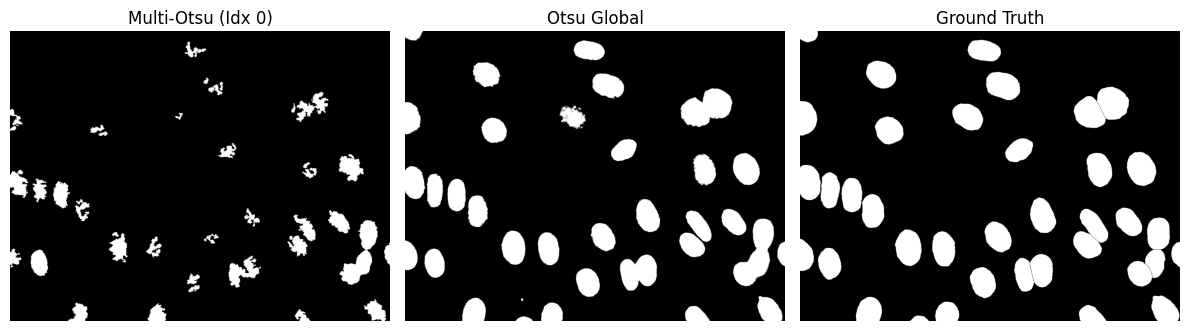

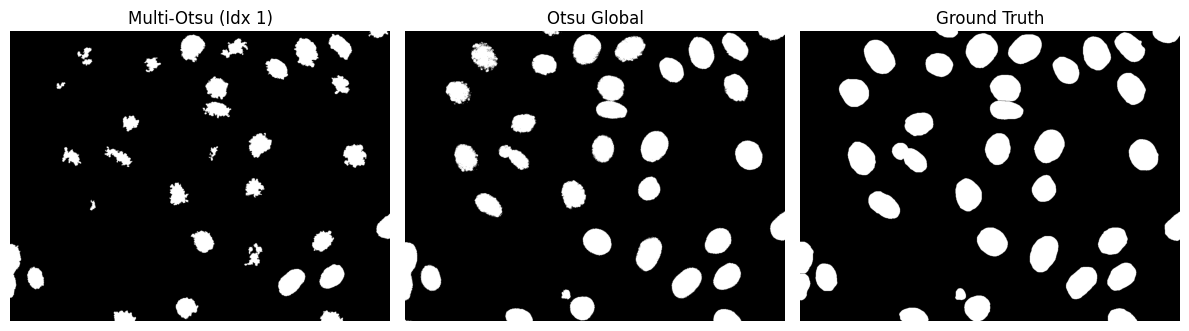

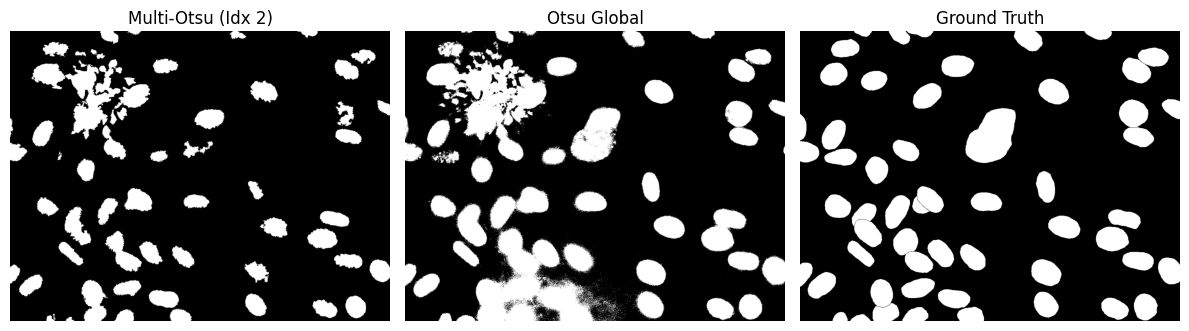

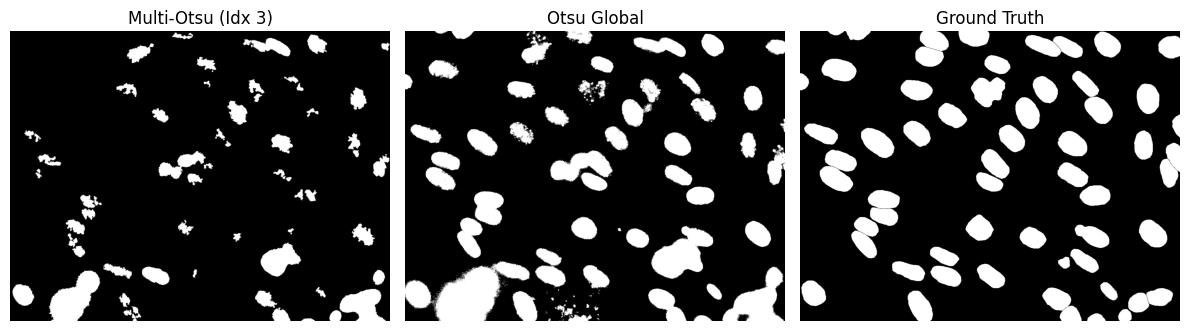

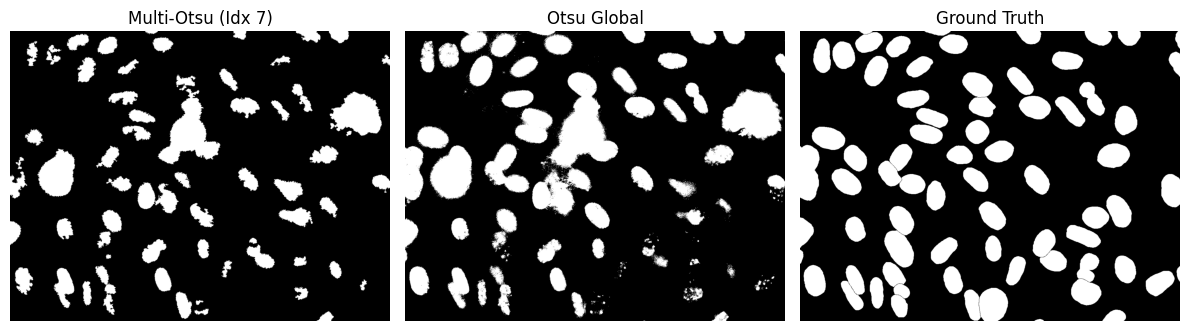

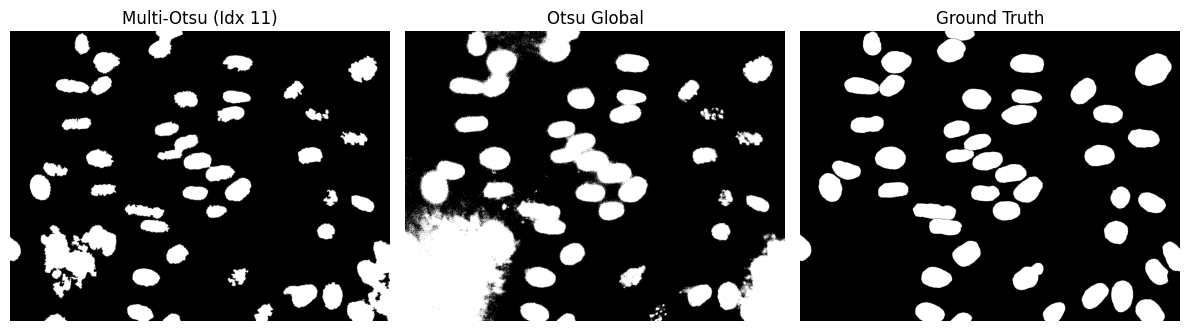

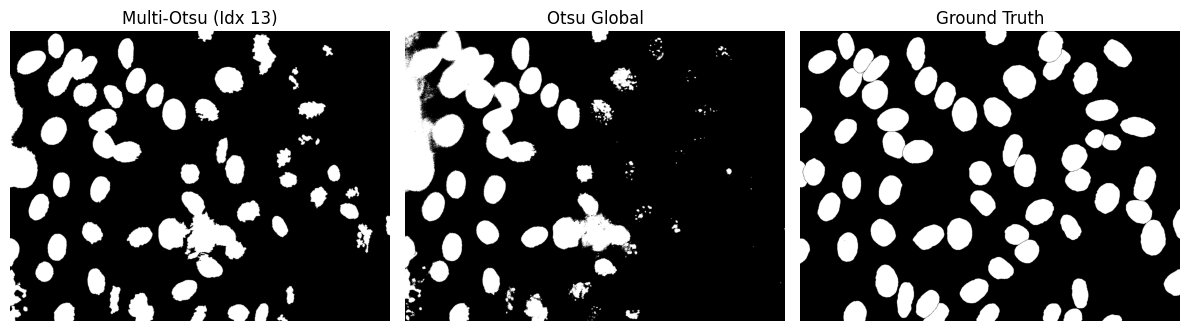

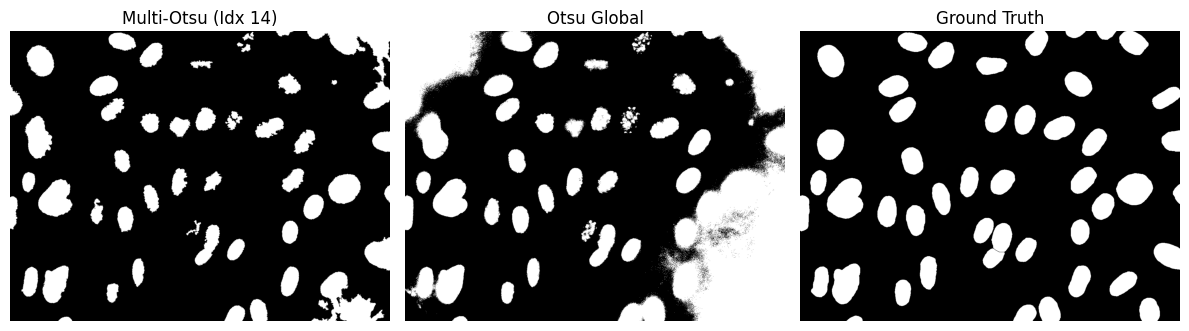

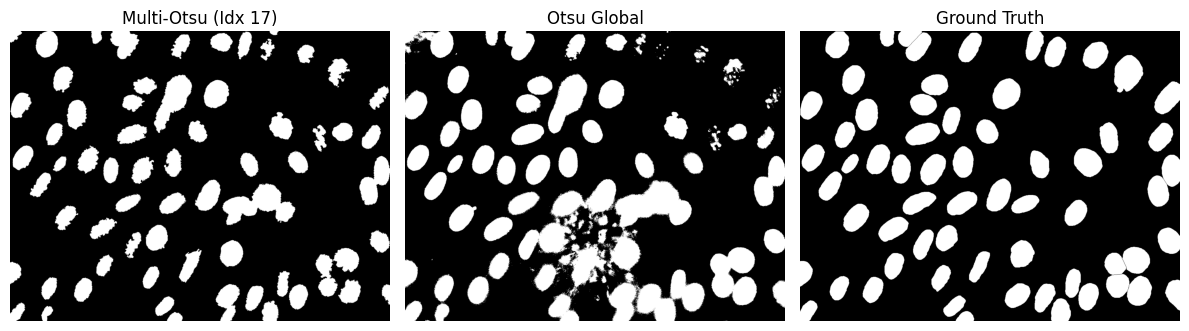

In [41]:
# -----------------------------------------
# Beispiel: Berechne alle Masken mit der bevorzugten Methode:
#multi_masks = [apply_multiotsu_hellste_klasse(img) for img in imgs_NIH3T3]
#multi_masks = [apply_multiotsu_clahe_hellste(img) for img in imgs_NIH3T3]
multi_masks = [apply_multiotsu_clahe_clean(img) for img in imgs_NIH3T3]  # <<== am robustesten

# Otsu-Global-Masken bleiben gleich
otsu_masks = [img > otsu_threshold_skimage_like(img) for img in imgs_NIH3T3]

# Für alle roten Punkte plots erzeugen
for idx in red_indices:
    img_multi = multi_masks[idx]
    img_otsu = otsu_masks[idx]
    img_gt = gts_NIH3T3[idx] > 0  # Ground truth binär

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(img_multi, cmap="gray")
    axes[0].set_title(f"Multi-Otsu (Idx {idx})")
    axes[0].axis("off")
    
    axes[1].imshow(img_otsu, cmap="gray")
    axes[1].set_title("Otsu Global")
    axes[1].axis("off")
    
    axes[2].imshow(img_gt, cmap="gray")
    axes[2].set_title("Ground Truth")
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()

In [34]:
# Dice Score Methode 1: nur hellste Klasse (basic)
def calculate_multiotsu_dice_scores_hellste_klasse(imgs, gts):
    scores = []
    for img, gt in zip(imgs, gts):
        mask = apply_multiotsu_hellste_klasse(img)
        gt_binary = gt > 0
        scores.append(dice_score(mask, gt_binary))
    return scores

# Dice Score Methode 2: CLAHE + hellste Klasse
def calculate_multiotsu_dice_scores_clahe_hellste(imgs, gts):
    scores = []
    for img, gt in zip(imgs, gts):
        mask = apply_multiotsu_clahe_hellste(img)
        gt_binary = gt > 0
        scores.append(dice_score(mask, gt_binary))
    return scores

# Methode 3: CLAHE + hellste Klasse + Rauschreduktion
def calculate_multiotsu_dice_scores_clahe_clean(imgs, gts):
    scores = []
    for img, gt in zip(imgs, gts):
        mask = apply_multiotsu_clahe_clean(img)
        gt_binary = gt > 0
        scores.append(dice_score(mask, gt_binary))
    return scores


def calculate_otsu_dice_scores(imgs, gts):
    scores = []
    for img, gt in zip(imgs, gts):
        t = otsu_threshold_skimage_like(img)
        mask = img > t  # Schwelle auf das Bild anwenden
        gt_binary = gt > 0
        scores.append(dice_score(mask, gt_binary))
    return scores

In [ ]:
dice_nih_multi_hellste_klasse   = calculate_multiotsu_dice_scores_hellste_klasse(imgs_NIH3T3, gts_NIH3T3)
dice_nih_multi_clahe_hellste  = calculate_multiotsu_dice_scores_clahe_hellste(imgs_NIH3T3, gts_NIH3T3)
dice_nih_multi_clahe_clean   = calculate_multiotsu_dice_scores_clahe_clean(imgs_NIH3T3, gts_NIH3T3)
dice_otsu = calculate_otsu_dice_scores(imgs_NIH3T3, gts_NIH3T3)
dice_multi_class1_foreground = calculate_multiotsu_dice_scores(imgs_NIH3T3, gts_NIH3T3)
# Als normale Floats ausgeben
# Nur die roten Bilder ausgeben
dice_nih_hellste_klasse_red = [dice_nih_multi_hellste_klasse[idx] for idx in red_indices]
dice_nih_clahe_hellste_red = [dice_nih_multi_clahe_hellste[idx] for idx in red_indices]
dice_nih_clahe_clean_red = [dice_nih_multi_clahe_clean[idx] for idx in red_indices]
dice_otsu_red = [dice_otsu[idx] for idx in red_indices]
multi_red = [dice_multi_class1_foreground[idx] for idx in red_indices]

print("\n--- Nur rote Bilder (package Dice > our Dice) ---")
print("NIH3T3_Scores_Multi_hellste_klasse =", ", ".join(f"{score}" for score in dice_nih_hellste_klasse_red))
print("NIH3T3_Scores_Multi_clahe_hellste =", ", ".join(f"{score}" for score in dice_nih_clahe_hellste_red))
print("NIH3T3_Scores_Multi_clahe_clean =", ", ".join(f"{score}" for score in dice_nih_clahe_clean_red))
print("Otsu =", ", ".join(f"{score}" for score in dice_otsu_red))
print("NIH3T3_multi_class1_foreground =", ", ".join(f"{score}" for score in multi_red))


--- Nur rote Bilder (package Dice > our Dice) ---
NIH3T3_Scores_Multi_hellste_klasse = 0.38114679613667046, 0.4998477719781168, 0.72534017201804, 0.008528883711823289, 0.0595030531325373, 0.6494941164638439, 0.3778144147247718, 0.591355824401558, 0.7795423555612154
NIH3T3_Scores_Multi_clahe_hellste = 0.5438057294631, 0.621976323786349, 0.7174265278881542, 0.45390658061174227, 0.6082199626678996, 0.7214816593362219, 0.7270616156074158, 0.7768795055579303, 0.7623251120610111
NIH3T3_Scores_Multi_clahe_clean = 0.5094471533056073, 0.6014682947240291, 0.7100143382460521, 0.4260210089971266, 0.5940824769598917, 0.724281331368268, 0.7238283866460274, 0.7747382038848035, 0.7646645282481035
Otsu = 0.9128436675562167, 0.8845252721173281, 0.8225479821936802, 0.758336987687637, 0.7237186625334818, 0.6762501531852865, 0.5757554586315079, 0.6165448260228947, 0.7925039681767514
NIH3T3_multi_class1_foreground = 0.7920301161671823, 0.7266143352296371, 0.2789833540967043, 0.7576211555278375, 0.709402236

Dice scores identical to reference: False


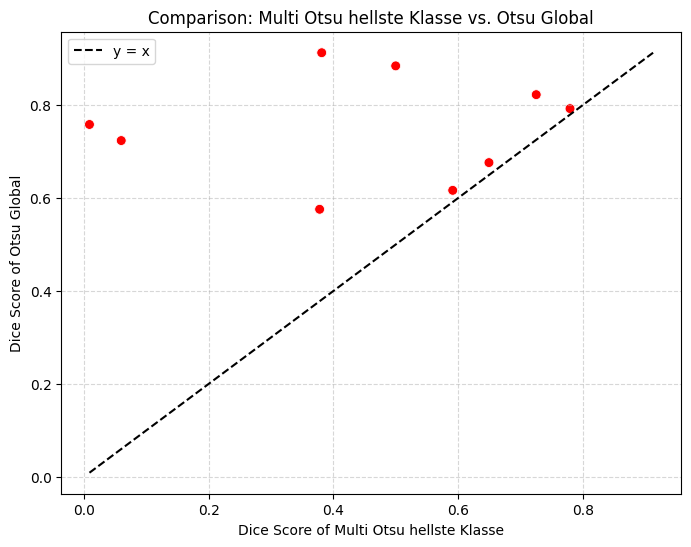

In [36]:
# Define Dice scores obtained from both methods for comparison.
# package_dice_scores: Dice scores from the reference implementation.
# our_dice_scores: Dice scores from our custom implementation.
dice_scores_multi_nih_Otsu = dice_otsu_red

dice_nih_multi_hellste_klasse
# Verify whether both lists are identical element-wise.
are_identical_multi_hellste_klasse = dice_scores_multi_nih_Otsu == dice_nih_hellste_klasse_red
print("Dice scores identical to reference:", are_identical_multi_hellste_klasse)

# Compute linear regression between our Dice scores (x) and package Dice scores (y).
slope, intercept = np.polyfit(dice_nih_hellste_klasse_red, dice_scores_multi_nih_Otsu, 1)

# Determine point colors for scatter plot based on relative performance.
colors = []
for x, y in zip(dice_nih_hellste_klasse_red, dice_scores_multi_nih_Otsu):
    if np.isclose(y, x):
        colors.append("blue")   # scores are essentially identical
    elif y > x:
        colors.append("red")    # package score higher → our method worse
    else:
        colors.append("green")  # our score higher → our method better

# Prepare DataFrame for seaborn plotting.
df = pd.DataFrame({
    "Multi": dice_nih_hellste_klasse_red,
    "Otsu Global": dice_scores_multi_nih_Otsu,
    "Color": colors
})

# Create scatter plot with seaborn.
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="Multi",
    y="Otsu Global",
    hue="Color",
    palette={"red": "red", "green": "green", "blue": "blue"},
    legend=False,
    s=50
)

# Plot regression line based on fitted linear model.
#x_fit = np.linspace(min(our_dice_scores), max(package_dice_scores), 100)
#y_fit = slope * x_fit + intercept
#sns.lineplot(x=x_fit, y=y_fit, color="orange", label="Regression", linestyle="-")

# Plot identity line y=x for reference of perfect agreement.
min_val, max_val = min(min(dice_nih_hellste_klasse_red), min(dice_scores_multi_nih_Otsu)), max(max(dice_nih_hellste_klasse_red), max(dice_scores_multi_nih_Otsu))
sns.lineplot(x=[min_val, max_val], y=[min_val, max_val], color="black", linestyle="--", label="y = x")

# Set axis labels and title.
plt.xlabel("Dice Score of Multi Otsu hellste Klasse")
plt.ylabel("Dice Score of Otsu Global")
plt.title("Comparison: Multi Otsu hellste Klasse vs. Otsu Global")

# Finalize plot with grid and legend.
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# Show plot window.
plt.show()

Dice scores identical to reference: False


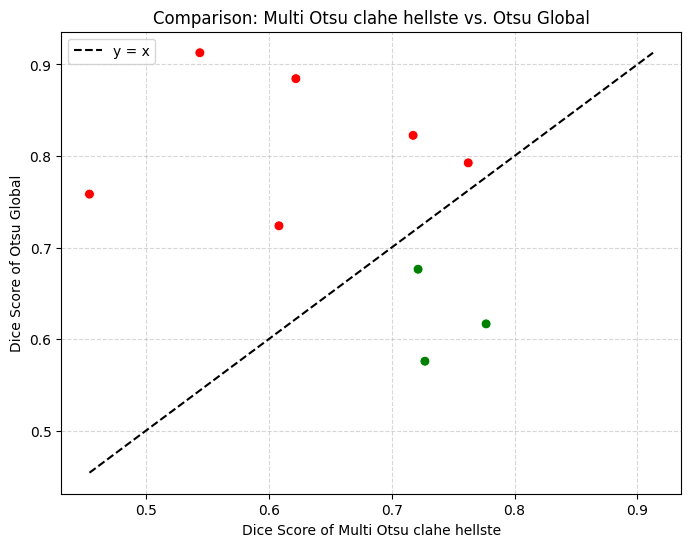

In [37]:
# Define Dice scores obtained from both methods for comparison.
# package_dice_scores: Dice scores from the reference implementation.
# our_dice_scores: Dice scores from our custom implementation.
dice_scores_multi_nih_Otsu = dice_otsu_red

dice_nih_clahe_hellste_red
# Verify whether both lists are identical element-wise.
are_identical_multi_clahe_hellste = dice_scores_multi_nih_Otsu == dice_nih_clahe_hellste_red
print("Dice scores identical to reference:", are_identical_multi_clahe_hellste)

# Compute linear regression between our Dice scores (x) and package Dice scores (y).
slope, intercept = np.polyfit(dice_nih_clahe_hellste_red, dice_scores_multi_nih_Otsu, 1)

# Determine point colors for scatter plot based on relative performance.
colors = []
for x, y in zip(dice_nih_clahe_hellste_red, dice_scores_multi_nih_Otsu):
    if np.isclose(y, x):
        colors.append("blue")   # scores are essentially identical
    elif y > x:
        colors.append("red")    # package score higher → our method worse
    else:
        colors.append("green")  # our score higher → our method better

# Prepare DataFrame for seaborn plotting.
df = pd.DataFrame({
    "Multi": dice_nih_clahe_hellste_red,
    "Otsu Global": dice_scores_multi_nih_Otsu,
    "Color": colors
})

# Create scatter plot with seaborn.
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="Multi",
    y="Otsu Global",
    hue="Color",
    palette={"red": "red", "green": "green", "blue": "blue"},
    legend=False,
    s=50
)

# Plot regression line based on fitted linear model.
#x_fit = np.linspace(min(our_dice_scores), max(package_dice_scores), 100)
#y_fit = slope * x_fit + intercept
#sns.lineplot(x=x_fit, y=y_fit, color="orange", label="Regression", linestyle="-")

# Plot identity line y=x for reference of perfect agreement.
min_val, max_val = min(min(dice_nih_clahe_hellste_red), min(dice_scores_multi_nih_Otsu)), max(max(dice_nih_clahe_hellste_red), max(dice_scores_multi_nih_Otsu))
sns.lineplot(x=[min_val, max_val], y=[min_val, max_val], color="black", linestyle="--", label="y = x")

# Set axis labels and title.
plt.xlabel("Dice Score of Multi Otsu clahe hellste")
plt.ylabel("Dice Score of Otsu Global")
plt.title("Comparison: Multi Otsu clahe hellste vs. Otsu Global")

# Finalize plot with grid and legend.
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# Show plot window.
plt.show()

Dice scores identical to reference: False


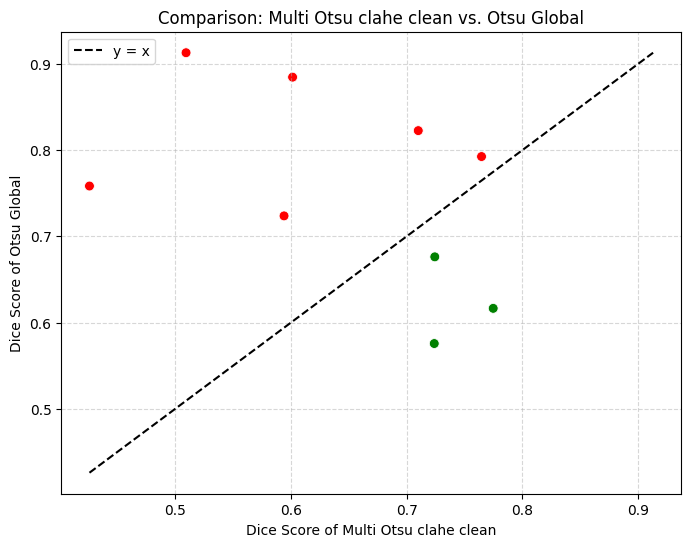

In [38]:
# Define Dice scores obtained from both methods for comparison.
# package_dice_scores: Dice scores from the reference implementation.
# our_dice_scores: Dice scores from our custom implementation.
dice_scores_multi_nih_Otsu = dice_otsu_red

dice_nih_clahe_clean_red
# Verify whether both lists are identical element-wise.
are_identical_multi_clahe_clean = dice_scores_multi_nih_Otsu == dice_nih_clahe_clean_red
print("Dice scores identical to reference:", are_identical_multi_clahe_clean)

# Compute linear regression between our Dice scores (x) and package Dice scores (y).
slope, intercept = np.polyfit(dice_nih_clahe_clean_red, dice_scores_multi_nih_Otsu, 1)

# Determine point colors for scatter plot based on relative performance.
colors = []
for x, y in zip(dice_nih_clahe_clean_red, dice_scores_multi_nih_Otsu):
    if np.isclose(y, x):
        colors.append("blue")   # scores are essentially identical
    elif y > x:
        colors.append("red")    # package score higher → our method worse
    else:
        colors.append("green")  # our score higher → our method better

# Prepare DataFrame for seaborn plotting.
df = pd.DataFrame({
    "Multi": dice_nih_clahe_clean_red,
    "Otsu Global": dice_scores_multi_nih_Otsu,
    "Color": colors
})

# Create scatter plot with seaborn.
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="Multi",
    y="Otsu Global",
    hue="Color",
    palette={"red": "red", "green": "green", "blue": "blue"},
    legend=False,
    s=50
)

# Plot regression line based on fitted linear model.
#x_fit = np.linspace(min(our_dice_scores), max(package_dice_scores), 100)
#y_fit = slope * x_fit + intercept
#sns.lineplot(x=x_fit, y=y_fit, color="orange", label="Regression", linestyle="-")

# Plot identity line y=x for reference of perfect agreement.
min_val, max_val = min(min(dice_nih_clahe_clean_red), min(dice_scores_multi_nih_Otsu)), max(max(dice_nih_clahe_clean_red), max(dice_scores_multi_nih_Otsu))
sns.lineplot(x=[min_val, max_val], y=[min_val, max_val], color="black", linestyle="--", label="y = x")

# Set axis labels and title.
plt.xlabel("Dice Score of Multi Otsu clahe clean")
plt.ylabel("Dice Score of Otsu Global")
plt.title("Comparison: Multi Otsu clahe clean vs. Otsu Global")

# Finalize plot with grid and legend.
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# Show plot window.
plt.show()